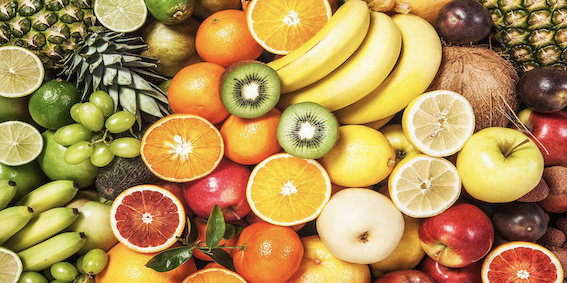

## Imports

In [1]:
import os
import numpy as np
import pandas as pd

from kaggle_datasets import KaggleDatasets
import tensorflow as tf

from tensorflow.keras.applications import DenseNet121

import cv2
from IPython.display import SVG

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Reading Images

In [2]:
TRAIN_PATH = '../input/fruits/fruits-360/Training'
TEST_PATH = '../input/fruits/fruits-360/Test'
TRAIN_FOLDERS = np.sort(os.listdir(TRAIN_PATH))
TEST_FOLDERS = np.sort(os.listdir(TEST_PATH))

# Working on 10 fruits only (130 varities will take a long time to train)
TRAIN_FOLDERS = np.array(pd.DataFrame(TRAIN_FOLDERS).sample(10)).reshape(-1)

TEST_FOLDERS = TRAIN_FOLDERS

In [3]:
print(TRAIN_FOLDERS)

['Cauliflower' 'Watermelon' 'Nut Pecan' 'Onion Red' 'Apple Red Delicious'
 'Rambutan' 'Pear Forelle' 'Lychee' 'Pear Abate' 'Raspberry']


In [4]:
## Creating an array of one sample of each type of fruit

train_images = []

path_root = '../input/fruits/fruits-360/Test/'
for fruit_name in TEST_FOLDERS:
    images = os.listdir(path_root + fruit_name)[:1]
    for file_name in images:
        image_path = path_root+fruit_name+'/'+file_name
        
        image = cv2.imread(image_path)
        train_images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
train_images = np.array(train_images)

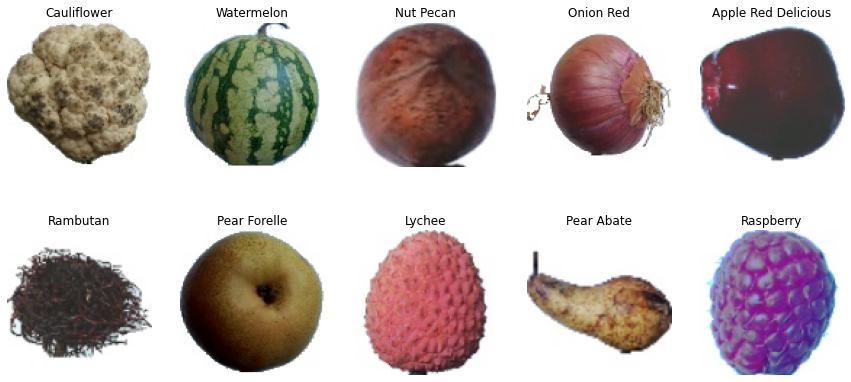

In [5]:
def display_images():
    rows, col = 2, 5
    #rows, col = 2, 2
    fig = plt.figure(figsize=(15,7))
    for index, image in enumerate(train_images):
        ax = fig.add_subplot(rows, col, index+1)
        ax.imshow(train_images[index])
        ax.set_title(TRAIN_FOLDERS[index])
        ax.axis('off')
        
    plt.show()
    
display_images()

In [6]:
train_labels = []
test_labels = []

def generate_train_labels():
    for fruit_name in TRAIN_FOLDERS:
        images = os.listdir('../input/fruits/fruits-360/Training/'+fruit_name)
        for image in range(len(images)):
            train_labels.append(fruit_name)
            
def generate_test_labels():
    for fruit_name in TEST_FOLDERS:
        images = os.listdir('../input/fruits/fruits-360/Test/'+fruit_name)
        for image in range(len(images)):
            test_labels.append(fruit_name)

generate_train_labels()
generate_test_labels()

train_labels = pd.get_dummies(train_labels)
test_labels = pd.get_dummies(test_labels)

labels = train_labels

train_labels = np.float32(train_labels[list(TRAIN_FOLDERS)].values)
test_labels = np.float32(test_labels[list(TEST_FOLDERS)].values)

train_labels[:3]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [7]:
fig = go.Figure(
                [go.Pie(labels=TRAIN_FOLDERS, 
                        values=labels.sum().values,
                        marker=dict(colors=['#026416','#C73104','#C05209','#6F2F05']))
                ])

fig.update_layout(width=900, height=400, title= {'text': "Fruit Categories Distribution",
                                                'y':0.95,'x':0.43,
                                                'xanchor': 'center','yanchor': 'top'},
                 margin = dict(l=50, r=10, t=50, b=30))

## Generating GCS path for TPU processing

In [8]:
GCS_PATH = KaggleDatasets().get_gcs_path()

test_path = []
train_path = []

def generate_test_path():
    path_root = GCS_PATH + '/fruits-360/Test/'
    for fruit_name in TEST_FOLDERS:
        images = os.listdir('../input/fruits/fruits-360/Test/'+fruit_name)
        for image in images:
            test_path.append(path_root+fruit_name+'/'+image)

def generate_train_path():
    path_root = GCS_PATH + '/fruits-360/Training/'
    for fruit_name in TRAIN_FOLDERS:
        images = os.listdir('../input/fruits/fruits-360/Training/'+fruit_name)
        for image in images:
            train_path.append(path_root+fruit_name+'/'+image)
            
generate_train_path()
generate_test_path()

In [9]:
train_path[:2]

['gs://kds-e55a3036d701844498d2e54578a96c7e755b178a0e2d115f7e9e2cca/fruits-360/Training/Cauliflower/r2_74_100.jpg',
 'gs://kds-e55a3036d701844498d2e54578a96c7e755b178a0e2d115f7e9e2cca/fruits-360/Training/Cauliflower/r_282_100.jpg']

In [10]:
print('Train :')
print('   Labels')
print('   ',train_labels.shape)
print('   Images')
print('   ',len(train_path))
print('')
print('Test :')
print('   Labels')
print('   ',test_labels.shape)
print('   Images')
print('   ',len(test_path))

Train :
   Labels
    (5315, 10)
   Images
    5315

Test :
   Labels
    (1781, 10)
   Images
    1781


## Image decoding and Augmentation

In [11]:
def decode_image(filename, label):
    image_size = (512,512)
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    return image, label

def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    return image, label

## TPU Configuration

* TPUs are network-connected accelerators and you must first locate them on the network. This is what TPUClusterResolver() does.

* Two additional lines of boilerplate and you can define a TPUStrategy. This object contains the necessary distributed training code that will work on TPUs with their 8 compute cores

* Batch size, learning rate
    
    To go fast on a TPU, increase the batch size. The rule of thumb is to use batches of 128 elements per core           (ex:      batch size of 128*8=1024 for a TPU with 8 cores).
            BATCH_SIZE = 16 * tpu_strategy.num_replicas_in_sync
* tf.data.Dataset and TFRecords
    
    Because TPUs are very fast, many models ported to TPU end up with a data bottleneck. The TPU is sitting             idle, waiting for data for the most part of each training epoch. TPUs read training data exclusively from           GCS (Google Cloud Storage). And GCS can sustain a pretty large throughput if it is continuously streaming           from multiple files in parallel.

In [12]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)


# instantiate a distribution strategy
strategy = tf.distribute.experimental.TPUStrategy(tpu)


BATCH_SIZE = 16 * strategy.num_replicas_in_sync

### Creating Train and Validation TF dataset

#### Parameters definition:
    
    1. Shuffle : the file names will be shuffled randomly
    
    2. Repeat: Repeats the dataset so each original value is seen multiple times , since we are 
               randomly augmenting(flipping) our images
    
    3. Prefetch : This allows later elements to be prepared while the current element is being processed. 
                  This often improves latency and throughput, at the cost of using additional memory to store 
                  prefetched elements.
    
    4. num_parallel_calls : tf.data.experimental.AUTOTUNE is used, then the number of parallel calls 
                            is set dynamically based on available CPU.

In [13]:
AUTO = tf.data.experimental.AUTOTUNE

train_dataset = (
        tf.data.Dataset\
        .from_tensor_slices((train_path, train_labels))\
        .map(decode_image, num_parallel_calls=AUTO)\
        .map(augment_image, num_parallel_calls=AUTO)\
        .repeat()\
        .shuffle(512)\
        .batch(BATCH_SIZE)\
        .prefetch(AUTO)\
        )

test_dataset = (
    tf.data.Dataset\
    .from_tensor_slices((test_path, test_labels))\
    .map(decode_image, num_parallel_calls=AUTO)\
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

## Modelling with DenseNet

In [14]:
with strategy.scope():
    model = tf.keras.models.Sequential()

    model.add(DenseNet121(
                     input_shape=(512,512,3),
                     weights = 'imagenet',
                     include_top=False))

    model.add(tf.keras.layers.GlobalAveragePooling2D())

    model.add(tf.keras.layers.Dense(train_labels.shape[1],
                                   activation='softmax'))

    model.compile(optimizer='adam', 
                 loss='categorical_crossentropy',
                 metrics=['categorical_accuracy'])


29089792/29084464 [==============================] - 0s 0us/step


### Learning rate scheduler

In [15]:
# Learning rate scheduler

def build_lrfn(lr_start=0.00001, lr_max=0.00005, 
               lr_min=0.00001, lr_rampup_epochs=5, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
callbacks_list = [lr_schedule]
STEPS_PER_EPOCH = train_labels.shape[0]//BATCH_SIZE

## Model Architecture

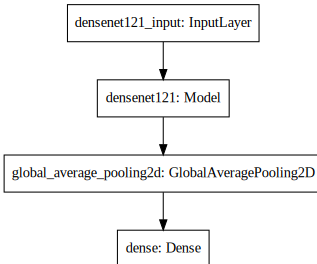

In [16]:
SVG(tf.keras.utils.model_to_dot(model, dpi=70).create(prog='dot', format='svg'))

## Training DenseNet

In [17]:
history = model.fit(train_dataset,
                    epochs = 10,
                    callbacks = callbacks_list,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    validation_data = test_dataset)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/10
41/41 [==============================] - 258s 6s/step - categorical_accuracy: 0.1107 - loss: 2.4519 - val_categorical_accuracy: 0.1185 - val_loss: 2.3894 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/10
41/41 [==============================] - 103s 3s/step - categorical_accuracy: 0.5943 - loss: 1.1985 - val_categorical_accuracy: 0.4453 - val_loss: 1.1927 - lr: 8.8000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/10
41/41 [==============================] - 127s 3s/step - categorical_accuracy: 0.8822 - loss: 0.4925 - val_categorical_accuracy: 0.7355 - val_loss: 1.0058 - lr: 1.6600e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/10
41/41 [==============================] - 122s 3s/step - categorical_accuracy: 0.9405 - loss: 0.2919 - val_categorical_accuracy: 0.3717 - val_loss: 3.0199 - lr:

### Displaying Training Curves

In [18]:
EPOCHS = 10
def display_training_curves(training, validation, yaxis):
    if yaxis == "loss":
        ylabel = "Loss"
        title = "Loss vs. Epochs"
    else:
        ylabel = "Accuracy"
        title = "Accuracy vs. Epochs"
        
    fig = go.Figure()
        
    fig.add_trace(
        go.Scatter(x=np.arange(1, EPOCHS+1), mode='lines+markers', y=training, marker=dict(color="dodgerblue"),
               name="Train"))
    
    fig.add_trace(
        go.Scatter(x=np.arange(1, EPOCHS+1), mode='lines+markers', y=validation, marker=dict(color="darkorange"),
               name="Val"))
    
    fig.update_layout(title_text=title, yaxis_title=ylabel, xaxis_title="Epochs", template="plotly_white")
    fig.show()

In [19]:
display_training_curves(
    history.history['categorical_accuracy'], 
    history.history['val_categorical_accuracy'], 
    'accuracy')

### Animation of Score vs EPOCH (click ▶️)

In [20]:
acc_df = pd.DataFrame(np.transpose([[*np.arange(1, EPOCHS+1).tolist()*3], ["Train"]*EPOCHS + ["Val"]*EPOCHS + ["Benchmark"]*EPOCHS,
                                     history.history['categorical_accuracy'] + history.history['val_categorical_accuracy'] + [1.0]*EPOCHS]))
acc_df.columns = ["Epochs", "Stage", "Accuracy"]
fig = px.bar(acc_df, x="Accuracy", y="Stage", animation_frame="Epochs", title="Accuracy vs. Epochs", color='Stage',
       color_discrete_map={"Train":"dodgerblue", "Val":"darkorange", "Benchmark":"seagreen"}, orientation="h")

fig.update_layout(
    xaxis = dict(
        autorange=False,
        range=[0, 1]
    )
)

fig.update_layout(template="plotly_white")

## Predicting Images from each class

Let's visualize some sample predictions made by the DenseNet model. 
The <font color="red">red</font> bars represent the model's prediction gone wrong, <br>
the <font color="green">green</font> represent the ground truth (label), and the rest of the bars are 
<font color="blue">blue</font>. <br>
When the model predicts correctly, the prediction bar is <font color="green">green</font>. <br>

Hover over the bars to check the probablity of prediction

In [21]:
def process(img):
    return cv2.resize(img/255.0, (512, 512)).reshape(-1, 512, 512, 3)
def predict(img):
    return model.layers[2](model.layers[1](model.layers[0](process(img)))).numpy()[0]

fig = make_subplots(rows=10, cols=2)


preds = predict(train_images[0])

colors = {TRAIN_FOLDERS[0]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[1]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[2]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[3]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[4]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[5]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[6]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[7]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[8]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[9]:px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = TRAIN_FOLDERS[0]
if list.index(preds.tolist(), max(preds)) == 1:
    pred = TRAIN_FOLDERS[1]
if list.index(preds.tolist(), max(preds)) == 2:
    pred = TRAIN_FOLDERS[2]
if list.index(preds.tolist(), max(preds)) == 3:
    pred = TRAIN_FOLDERS[3]
if list.index(preds.tolist(), max(preds)) == 0:
    pred = TRAIN_FOLDERS[4]
if list.index(preds.tolist(), max(preds)) == 1:
    pred = TRAIN_FOLDERS[5]
if list.index(preds.tolist(), max(preds)) == 2:
    pred = TRAIN_FOLDERS[6]
if list.index(preds.tolist(), max(preds)) == 3:
    pred = TRAIN_FOLDERS[7]
if list.index(preds.tolist(), max(preds)) == 1:
    pred = TRAIN_FOLDERS[8]
if list.index(preds.tolist(), max(preds)) == 2:
    pred = TRAIN_FOLDERS[9]

colors[pred] = px.colors.qualitative.Plotly[1]
colors[TRAIN_FOLDERS[0]] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[0], (205, 136))), row=1, col=1)
fig.add_trace(go.Bar(x=[TRAIN_FOLDERS[0],TRAIN_FOLDERS[1],TRAIN_FOLDERS[2],TRAIN_FOLDERS[3],TRAIN_FOLDERS[4],TRAIN_FOLDERS[5],TRAIN_FOLDERS[6],TRAIN_FOLDERS[7],TRAIN_FOLDERS[8],TRAIN_FOLDERS[9]], y=preds, marker=dict(color=colors)), row=1, col=2)
fig.update_layout(height=800, width=600, title_text="DenseNet Predictions", showlegend=False)



preds = predict(train_images[1])

colors = {TRAIN_FOLDERS[0]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[1]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[2]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[3]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[4]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[5]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[6]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[7]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[8]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[9]:px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = TRAIN_FOLDERS[0]
if list.index(preds.tolist(), max(preds)) == 1:
    pred = TRAIN_FOLDERS[1]
if list.index(preds.tolist(), max(preds)) == 2:
    pred = TRAIN_FOLDERS[2]
if list.index(preds.tolist(), max(preds)) == 3:
    pred = TRAIN_FOLDERS[3]
if list.index(preds.tolist(), max(preds)) == 0:
    pred = TRAIN_FOLDERS[4]
if list.index(preds.tolist(), max(preds)) == 1:
    pred = TRAIN_FOLDERS[5]
if list.index(preds.tolist(), max(preds)) == 2:
    pred = TRAIN_FOLDERS[6]
if list.index(preds.tolist(), max(preds)) == 3:
    pred = TRAIN_FOLDERS[7]
if list.index(preds.tolist(), max(preds)) == 1:
    pred = TRAIN_FOLDERS[8]
if list.index(preds.tolist(), max(preds)) == 2:
    pred = TRAIN_FOLDERS[9]

colors[pred] = px.colors.qualitative.Plotly[1]
colors[TRAIN_FOLDERS[1]] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[1], (205, 136))), row=2, col=1)
fig.add_trace(go.Bar(x=[TRAIN_FOLDERS[0],TRAIN_FOLDERS[1],TRAIN_FOLDERS[2],TRAIN_FOLDERS[3],TRAIN_FOLDERS[4],TRAIN_FOLDERS[5],TRAIN_FOLDERS[6],TRAIN_FOLDERS[7],TRAIN_FOLDERS[8],TRAIN_FOLDERS[9]], y=preds, marker=dict(color=colors)), row=2, col=2)
fig.update_layout(height=800, width=600, title_text="DenseNet Predictions", showlegend=False)


preds = predict(train_images[2])

colors = {TRAIN_FOLDERS[0]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[1]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[2]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[3]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[4]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[5]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[6]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[7]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[8]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[9]:px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = TRAIN_FOLDERS[0]
if list.index(preds.tolist(), max(preds)) == 1:
    pred = TRAIN_FOLDERS[1]
if list.index(preds.tolist(), max(preds)) == 2:
    pred = TRAIN_FOLDERS[2]
if list.index(preds.tolist(), max(preds)) == 3:
    pred = TRAIN_FOLDERS[3]
if list.index(preds.tolist(), max(preds)) == 0:
    pred = TRAIN_FOLDERS[4]
if list.index(preds.tolist(), max(preds)) == 1:
    pred = TRAIN_FOLDERS[5]
if list.index(preds.tolist(), max(preds)) == 2:
    pred = TRAIN_FOLDERS[6]
if list.index(preds.tolist(), max(preds)) == 3:
    pred = TRAIN_FOLDERS[7]
if list.index(preds.tolist(), max(preds)) == 1:
    pred = TRAIN_FOLDERS[8]
if list.index(preds.tolist(), max(preds)) == 2:
    pred = TRAIN_FOLDERS[9]

colors[pred] = px.colors.qualitative.Plotly[1]
colors[TRAIN_FOLDERS[2]] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[2], (205, 136))), row=3, col=1)
fig.add_trace(go.Bar(x=[TRAIN_FOLDERS[0],TRAIN_FOLDERS[1],TRAIN_FOLDERS[2],TRAIN_FOLDERS[3],TRAIN_FOLDERS[4],TRAIN_FOLDERS[5],TRAIN_FOLDERS[6],TRAIN_FOLDERS[7],TRAIN_FOLDERS[8],TRAIN_FOLDERS[9]], y=preds, marker=dict(color=colors)), row=3, col=2)
fig.update_layout(height=1200, width=800, title_text="DenseNet Predictions", showlegend=False)


preds = predict(train_images[3])

colors = {TRAIN_FOLDERS[0]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[1]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[2]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[3]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[4]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[5]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[6]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[7]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[8]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[9]:px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = TRAIN_FOLDERS[0]
if list.index(preds.tolist(), max(preds)) == 1:
    pred = TRAIN_FOLDERS[1]
if list.index(preds.tolist(), max(preds)) == 2:
    pred = TRAIN_FOLDERS[2]
if list.index(preds.tolist(), max(preds)) == 3:
    pred = TRAIN_FOLDERS[3]
if list.index(preds.tolist(), max(preds)) == 0:
    pred = TRAIN_FOLDERS[4]
if list.index(preds.tolist(), max(preds)) == 1:
    pred = TRAIN_FOLDERS[5]
if list.index(preds.tolist(), max(preds)) == 2:
    pred = TRAIN_FOLDERS[6]
if list.index(preds.tolist(), max(preds)) == 3:
    pred = TRAIN_FOLDERS[7]
if list.index(preds.tolist(), max(preds)) == 1:
    pred = TRAIN_FOLDERS[8]
if list.index(preds.tolist(), max(preds)) == 2:
    pred = TRAIN_FOLDERS[9]

colors[pred] = px.colors.qualitative.Plotly[1]
colors[TRAIN_FOLDERS[3]] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[3], (205, 136))), row=4, col=1)
fig.add_trace(go.Bar(x=[TRAIN_FOLDERS[0],TRAIN_FOLDERS[1],TRAIN_FOLDERS[2],TRAIN_FOLDERS[3],TRAIN_FOLDERS[4],TRAIN_FOLDERS[5],TRAIN_FOLDERS[6],TRAIN_FOLDERS[7],TRAIN_FOLDERS[8],TRAIN_FOLDERS[9]], y=preds, marker=dict(color=colors)), row=4, col=2)
fig.update_layout(height=1200, width=800, title_text="DenseNet Predictions", showlegend=False)

preds = predict(train_images[4])

colors = {TRAIN_FOLDERS[0]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[1]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[2]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[3]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[4]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[5]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[6]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[7]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[8]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[9]:px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = TRAIN_FOLDERS[0]
if list.index(preds.tolist(), max(preds)) == 1:
    pred = TRAIN_FOLDERS[1]
if list.index(preds.tolist(), max(preds)) == 2:
    pred = TRAIN_FOLDERS[2]
if list.index(preds.tolist(), max(preds)) == 3:
    pred = TRAIN_FOLDERS[3]
if list.index(preds.tolist(), max(preds)) == 0:
    pred = TRAIN_FOLDERS[4]
if list.index(preds.tolist(), max(preds)) == 1:
    pred = TRAIN_FOLDERS[5]
if list.index(preds.tolist(), max(preds)) == 2:
    pred = TRAIN_FOLDERS[6]
if list.index(preds.tolist(), max(preds)) == 3:
    pred = TRAIN_FOLDERS[7]
if list.index(preds.tolist(), max(preds)) == 1:
    pred = TRAIN_FOLDERS[8]
if list.index(preds.tolist(), max(preds)) == 2:
    pred = TRAIN_FOLDERS[9]

colors[pred] = px.colors.qualitative.Plotly[1]
colors[TRAIN_FOLDERS[4]] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[4], (205, 136))), row=5, col=1)
fig.add_trace(go.Bar(x=[TRAIN_FOLDERS[0],TRAIN_FOLDERS[1],TRAIN_FOLDERS[2],TRAIN_FOLDERS[3],TRAIN_FOLDERS[4],TRAIN_FOLDERS[5],TRAIN_FOLDERS[6],TRAIN_FOLDERS[7],TRAIN_FOLDERS[8],TRAIN_FOLDERS[9]], y=preds, marker=dict(color=colors)), row=5, col=2)
fig.update_layout(height=1200, width=800, title_text="DenseNet Predictions", showlegend=False)


preds = predict(train_images[5])

colors = {TRAIN_FOLDERS[0]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[1]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[2]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[3]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[4]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[5]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[6]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[7]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[8]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[9]:px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = TRAIN_FOLDERS[0]
if list.index(preds.tolist(), max(preds)) == 1:
    pred = TRAIN_FOLDERS[1]
if list.index(preds.tolist(), max(preds)) == 2:
    pred = TRAIN_FOLDERS[2]
if list.index(preds.tolist(), max(preds)) == 3:
    pred = TRAIN_FOLDERS[3]
if list.index(preds.tolist(), max(preds)) == 0:
    pred = TRAIN_FOLDERS[4]
if list.index(preds.tolist(), max(preds)) == 1:
    pred = TRAIN_FOLDERS[5]
if list.index(preds.tolist(), max(preds)) == 2:
    pred = TRAIN_FOLDERS[6]
if list.index(preds.tolist(), max(preds)) == 3:
    pred = TRAIN_FOLDERS[7]
if list.index(preds.tolist(), max(preds)) == 1:
    pred = TRAIN_FOLDERS[8]
if list.index(preds.tolist(), max(preds)) == 2:
    pred = TRAIN_FOLDERS[9]

colors[pred] = px.colors.qualitative.Plotly[1]
colors[TRAIN_FOLDERS[5]] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[5], (205, 136))), row=6, col=1)
fig.add_trace(go.Bar(x=[TRAIN_FOLDERS[0],TRAIN_FOLDERS[1],TRAIN_FOLDERS[2],TRAIN_FOLDERS[3],TRAIN_FOLDERS[4],TRAIN_FOLDERS[5],TRAIN_FOLDERS[6],TRAIN_FOLDERS[7],TRAIN_FOLDERS[8],TRAIN_FOLDERS[9]], y=preds, marker=dict(color=colors)), row=6, col=2)
fig.update_layout(height=1200, width=800, title_text="DenseNet Predictions", showlegend=False)


preds = predict(train_images[6])

colors = {TRAIN_FOLDERS[0]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[1]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[2]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[3]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[4]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[5]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[6]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[7]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[8]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[9]:px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = TRAIN_FOLDERS[0]
if list.index(preds.tolist(), max(preds)) == 1:
    pred = TRAIN_FOLDERS[1]
if list.index(preds.tolist(), max(preds)) == 2:
    pred = TRAIN_FOLDERS[2]
if list.index(preds.tolist(), max(preds)) == 3:
    pred = TRAIN_FOLDERS[3]
if list.index(preds.tolist(), max(preds)) == 0:
    pred = TRAIN_FOLDERS[4]
if list.index(preds.tolist(), max(preds)) == 1:
    pred = TRAIN_FOLDERS[5]
if list.index(preds.tolist(), max(preds)) == 2:
    pred = TRAIN_FOLDERS[6]
if list.index(preds.tolist(), max(preds)) == 3:
    pred = TRAIN_FOLDERS[7]
if list.index(preds.tolist(), max(preds)) == 1:
    pred = TRAIN_FOLDERS[8]
if list.index(preds.tolist(), max(preds)) == 2:
    pred = TRAIN_FOLDERS[9]

colors[pred] = px.colors.qualitative.Plotly[1]
colors[TRAIN_FOLDERS[6]] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[6], (205, 136))), row=7, col=1)
fig.add_trace(go.Bar(x=[TRAIN_FOLDERS[0],TRAIN_FOLDERS[1],TRAIN_FOLDERS[2],TRAIN_FOLDERS[3],TRAIN_FOLDERS[4],TRAIN_FOLDERS[5],TRAIN_FOLDERS[6],TRAIN_FOLDERS[7],TRAIN_FOLDERS[8],TRAIN_FOLDERS[9]], y=preds, marker=dict(color=colors)), row=7, col=2)
fig.update_layout(height=1200, width=800, title_text="DenseNet Predictions", showlegend=False)

preds = predict(train_images[7])

colors = {TRAIN_FOLDERS[0]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[1]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[2]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[3]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[4]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[5]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[6]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[7]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[8]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[9]:px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = TRAIN_FOLDERS[0]
if list.index(preds.tolist(), max(preds)) == 1:
    pred = TRAIN_FOLDERS[1]
if list.index(preds.tolist(), max(preds)) == 2:
    pred = TRAIN_FOLDERS[2]
if list.index(preds.tolist(), max(preds)) == 3:
    pred = TRAIN_FOLDERS[3]
if list.index(preds.tolist(), max(preds)) == 0:
    pred = TRAIN_FOLDERS[4]
if list.index(preds.tolist(), max(preds)) == 1:
    pred = TRAIN_FOLDERS[5]
if list.index(preds.tolist(), max(preds)) == 2:
    pred = TRAIN_FOLDERS[6]
if list.index(preds.tolist(), max(preds)) == 3:
    pred = TRAIN_FOLDERS[7]
if list.index(preds.tolist(), max(preds)) == 1:
    pred = TRAIN_FOLDERS[8]
if list.index(preds.tolist(), max(preds)) == 2:
    pred = TRAIN_FOLDERS[9]

colors[pred] = px.colors.qualitative.Plotly[1]
colors[TRAIN_FOLDERS[7]] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[7], (205, 136))), row=8, col=1)
fig.add_trace(go.Bar(x=[TRAIN_FOLDERS[0],TRAIN_FOLDERS[1],TRAIN_FOLDERS[2],TRAIN_FOLDERS[3],TRAIN_FOLDERS[4],TRAIN_FOLDERS[5],TRAIN_FOLDERS[6],TRAIN_FOLDERS[7],TRAIN_FOLDERS[8],TRAIN_FOLDERS[9]], y=preds, marker=dict(color=colors)), row=8, col=2)
fig.update_layout(height=1200, width=800, title_text="DenseNet Predictions", showlegend=False)


preds = predict(train_images[8])

colors = {TRAIN_FOLDERS[0]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[1]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[2]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[3]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[4]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[5]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[6]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[7]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[8]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[9]:px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = TRAIN_FOLDERS[0]
if list.index(preds.tolist(), max(preds)) == 1:
    pred = TRAIN_FOLDERS[1]
if list.index(preds.tolist(), max(preds)) == 2:
    pred = TRAIN_FOLDERS[2]
if list.index(preds.tolist(), max(preds)) == 3:
    pred = TRAIN_FOLDERS[3]
if list.index(preds.tolist(), max(preds)) == 0:
    pred = TRAIN_FOLDERS[4]
if list.index(preds.tolist(), max(preds)) == 1:
    pred = TRAIN_FOLDERS[5]
if list.index(preds.tolist(), max(preds)) == 2:
    pred = TRAIN_FOLDERS[6]
if list.index(preds.tolist(), max(preds)) == 3:
    pred = TRAIN_FOLDERS[7]
if list.index(preds.tolist(), max(preds)) == 1:
    pred = TRAIN_FOLDERS[8]
if list.index(preds.tolist(), max(preds)) == 2:
    pred = TRAIN_FOLDERS[9]

colors[pred] = px.colors.qualitative.Plotly[1]
colors[TRAIN_FOLDERS[8]] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[8], (205, 136))), row=9, col=1)
fig.add_trace(go.Bar(x=[TRAIN_FOLDERS[0],TRAIN_FOLDERS[1],TRAIN_FOLDERS[2],TRAIN_FOLDERS[3],TRAIN_FOLDERS[4],TRAIN_FOLDERS[5],TRAIN_FOLDERS[6],TRAIN_FOLDERS[7],TRAIN_FOLDERS[8],TRAIN_FOLDERS[9]], y=preds, marker=dict(color=colors)), row=9, col=2)


preds = predict(train_images[9])

colors = {TRAIN_FOLDERS[0]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[1]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[2]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[3]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[4]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[5]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[6]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[7]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[8]:px.colors.qualitative.Plotly[0], TRAIN_FOLDERS[9]:px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = TRAIN_FOLDERS[0]
if list.index(preds.tolist(), max(preds)) == 1:
    pred = TRAIN_FOLDERS[1]
if list.index(preds.tolist(), max(preds)) == 2:
    pred = TRAIN_FOLDERS[2]
if list.index(preds.tolist(), max(preds)) == 3:
    pred = TRAIN_FOLDERS[3]
if list.index(preds.tolist(), max(preds)) == 0:
    pred = TRAIN_FOLDERS[4]
if list.index(preds.tolist(), max(preds)) == 1:
    pred = TRAIN_FOLDERS[5]
if list.index(preds.tolist(), max(preds)) == 2:
    pred = TRAIN_FOLDERS[6]
if list.index(preds.tolist(), max(preds)) == 3:
    pred = TRAIN_FOLDERS[7]
if list.index(preds.tolist(), max(preds)) == 1:
    pred = TRAIN_FOLDERS[8]
if list.index(preds.tolist(), max(preds)) == 2:
    pred = TRAIN_FOLDERS[9]

colors[pred] = px.colors.qualitative.Plotly[1]
colors[TRAIN_FOLDERS[9]] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[9], (205, 136))), row=10, col=1)
fig.add_trace(go.Bar(x=[TRAIN_FOLDERS[0],TRAIN_FOLDERS[1],TRAIN_FOLDERS[2],TRAIN_FOLDERS[3],TRAIN_FOLDERS[4],TRAIN_FOLDERS[5],TRAIN_FOLDERS[6],TRAIN_FOLDERS[7],TRAIN_FOLDERS[8],TRAIN_FOLDERS[9]], y=preds, marker=dict(color=colors)), row=10, col=2)
fig.update_layout(height=1800, width=1000, title_text="DenseNet Predictions", showlegend=False)
fig.update_layout(template="plotly_white")